In [59]:
import random
from scipy.io import arff

from sklearn import ensemble, neighbors, svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from scipy.optimize import curve_fit
from collections import Counter
from sklearn.preprocessing import StandardScaler
from itertools import chain

import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root_scalar

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [85]:
#User defined parameters
# 1. model_func is the extrapolation function to be used.
# You can choose from: exp, exp_saturation, power_law and inverse. The functions are defined below. 
# You can also add your customized function here

model_func = exp

#2. Error threshold - indicates how much error we can tolerate with respect to the performance expected. Default is taken as 1% tolerance.
threshold = 0.01

txt = "Exponential"
x_lim = 2000 #
num_points_generated = 30
prediction_error_threshold = 0.005

Predicted Sample Size can not be estimated by root finding method.
Fallback estimated sample size: 4659


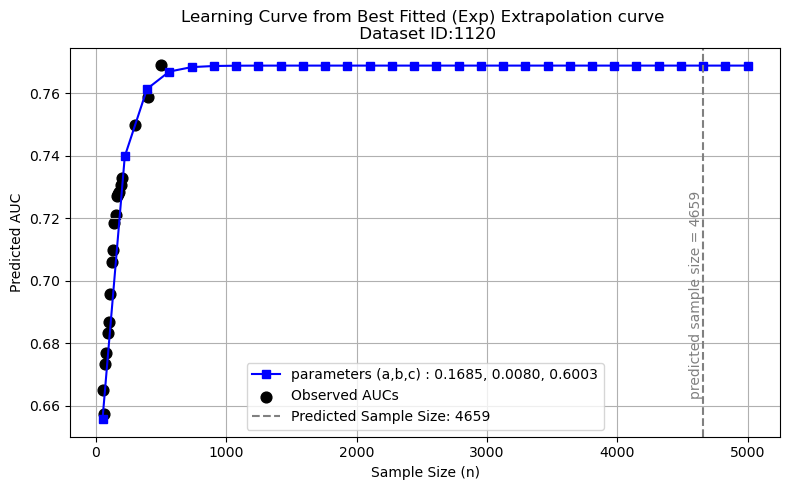

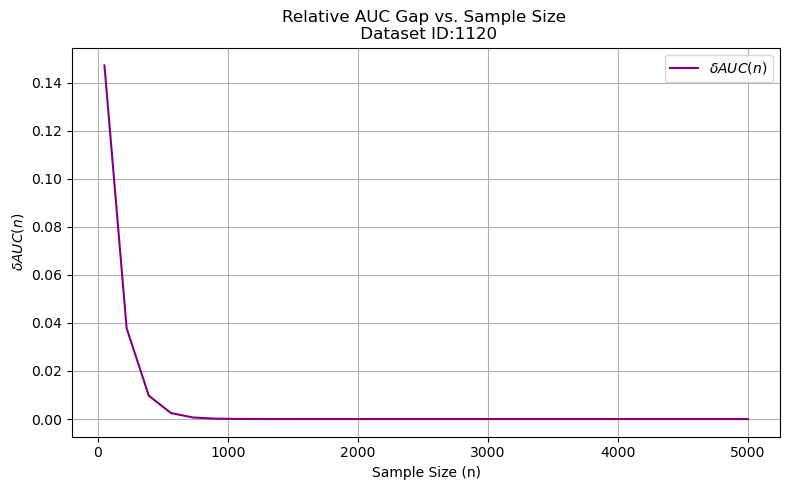

In [97]:
# Define extrapolation functions

def exp(n, a, b, c):
    return np.clip(a * (1 - np.exp(-b * n)) + c, 0, 1)

def exp_saturation(n, a, b, c):
    exponent = np.clip(-c * n, -700, 700)  # np.exp() overflow limit is ~709
    return np.clip(a - b * np.exp(exponent), 0, 1)
    #return a - b * np.exp(-c * n)
    
def power_law(n, a, b, c):
    return a - b * n**(-c)

def inverse(n, a, b, c):
    return a - b / (n + c)

func_map = {
    "exp": exp,
    "exp_saturation": exp_saturation,
    "power_law": power_law,
    "inverse": inverse
}

# Read data
with open("test.txt", 'r') as temp_f:
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names
column_names = [i for i in range(0, max(col_count))]

df = pd.read_csv("test.txt", header=None, delimiter=",", names=column_names)

i = i1 = 0
row_df = df.iloc[i,:]
v = len(row_df)
rep_auc = np.array(df.iloc[i,2:v])
sslen = len(rep_auc)

samplesize_list = []
max_samples = 50000
sample_size = 50
samplesize_list.append(sample_size)
for i in range(sslen-1):
    if sample_size < 200 and sample_size < max_samples:
        sample_size_incr = 10
    elif sample_size >= 200 and sample_size < 1000 and sample_size < max_samples:
        sample_size_incr = 100
    elif sample_size >= 1000 and sample_size < max_samples:
        sample_size_incr = 500
    sample_size = sample_size + sample_size_incr
    samplesize_list.append(sample_size)

sample_sizes = np.array(samplesize_list)
auc_values = np.array(rep_auc)

row = row_df
did = row[0]
algo = row[1]
max_auc = float(row.iloc[-1])
target_auc = max_auc + 0.01 if max_auc < 0.99 else 0.99  # Setting a slightly futuristic target

best_func = None
best_params = None
lowest_rmse = float('inf')

for name, func in func_map.items():
    try:
        p0 = [0.9, 0.01, 0.1]
        popt, _ = curve_fit(func, sample_sizes, auc_values, p0=p0, maxfev=5000)
        y_pred = func(sample_sizes, *popt)
        rmse = np.sqrt(np.mean((auc_values - y_pred) ** 2))
        if rmse < lowest_rmse:
            best_func = func
            best_params = popt
            lowest_rmse = rmse
            best_name = name
    except Exception as e:
        continue

if best_func is None:
    raise ValueError("Could not fit any extrapolation model.")

# root-solving objective
limiting_auc = float(best_func(1e9, *best_params))
x_vals = np.linspace(min(sample_sizes), 5000, 30)
y_vals = np.clip(best_func(x_vals, *best_params), 0, 1.0)

try:
    if limiting_auc < target_auc:
        print("Predicted Sample Size can not be estimated by root finding method.")
    def objective(n):
        return best_func(n, *best_params) - target_auc
    result = root_scalar(objective, bracket=[1, 1e9], method='brentq')
    predicted_sample_size = result.root if result.converged else None
except:
    diffs = np.abs(y_vals - target_auc)
    idx_closest = np.where(diffs <= prediction_error_threshold)[0]
    predicted_sample_size = x_vals[idx_closest[0]] if len(idx_closest) > 0 else x_vals[np.argmin(diffs)]
    print(f"Fallback estimated sample size: {predicted_sample_size:.0f}")
    
# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, label=f"parameters (a,b,c) : " + \
         ", ".join([f"{p:.4f}" for p in best_params]), color='blue', marker='s')
plt.scatter(sample_sizes, auc_values, color='black', marker='o', s=60, label="Observed AUCs")
if predicted_sample_size:
    plt.axvline(predicted_sample_size, linestyle='--', color='gray', label=f"Predicted Sample Size: {predicted_sample_size:.0f}")
    plt.text(predicted_sample_size, target_auc - 0.05, f"predicted sample size = {predicted_sample_size:.0f}", rotation=90, verticalalignment='top', horizontalalignment='right', color='gray')
#plt.axhline(target_auc, linestyle=':', color='red', label=f"Target AUC: {target_auc:.3f}")
plt.xlabel("Sample Size (n)")
plt.ylabel("Predicted AUC")
#plt.ylim(0.5,1.05)
plt.title("Learning Curve from Best Fitted (" + best_name.capitalize() + ") Extrapolation curve \n Dataset ID:" + str(did))
plt.grid(True)
plt.legend()
plt.tight_layout()
filename = "LC_best_" + str(did) + "_" + algo
plt.savefig(filename)

# Plot delta AUC
auc_max = max(y_vals)
delta_auc = 1 - (y_vals / auc_max)
plt.figure(figsize=(8, 5))
plt.plot(x_vals, delta_auc, label=r'$\delta AUC(n)$', color='purple')
plt.xlabel("Sample Size (n)")
plt.ylabel(r"$\delta AUC(n)$")
plt.title("Relative AUC Gap vs. Sample Size \n Dataset ID:" + str(did))
plt.grid(True)
plt.legend()
plt.tight_layout()
filename = "Gap_best_" + str(did) + "_" + algo
plt.savefig(filename)